In [1]:
if !(pwd() in LOAD_PATH)
    push!(LOAD_PATH,pwd())
end
using BayesianIPR
using Turing
using LinearAlgebra
using Statistics
using Plots
using LaTeXStrings

In [2]:
R2 = IMPR([
        [Interval(1,1)      Interval(2,5)   Interval(2,4)   Interval(1,3)];
        [Interval(1/5,1/2)  Interval(1,1)   Interval(1,3)   Interval(1,2)];
        [Interval(1/4,1/2)  Interval(1/3,1) Interval(1,1)   Interval(1/2,1)];
        [Interval(1/3,1)    Interval(1/2,1) Interval(1,2)   Interval(1,1)]
])

[1.0, 1.0]	[2.0, 5.0]	[2.0, 4.0]	[1.0, 3.0]	
[0.2, 0.5]	[1.0, 1.0]	[1.0, 3.0]	[1.0, 2.0]	
[0.25, 0.5]	[0.33, 1.0]	[1.0, 1.0]	[0.5, 1.0]	
[0.33, 1.0]	[0.5, 1.0]	[1.0, 2.0]	[1.0, 1.0]	


In [3]:
X,L,U,J,r,n,n_J = getdata(log.(R2.R));
w_prior = [0.4,0.3,0.1,0.2]
u_prior = log.(w_prior[1:(end-1)]) .- log(w_prior[n])

b_prior = 0.1

a = 0.1
p = a^2
λ_b = 0.1
λ_mu = 10000
post = IntervalAHP.iahp_analy(X,L,U,n,n_J,a,p,u_prior,λ_mu,b_prior,λ_b)

Dict{String, Any} with 6 entries:
  "μ"    => Dict{String, Any}("dof"=>12.01, "S"=>[2.35789e-5 4.71389e-9 4.71389…
  "ϕ"    => Dict("α"=>6.005, "mean"=>4.23854, "β"=>1.41676, "var"=>2.99171)
  "b"    => Dict("v"=>0.0826446, "dof"=>12.01, "m"=>0.429996, "mean"=>0.429996,…
  "lci"  => 0.131392
  "prci" => 0.34039
  "pci"  => 0.471782

In [6]:
chn = sample(IntervalAHP.iahp(X,L,U,n,n_J,a,p,u_prior,λ_mu,b_prior,λ_b),NUTS(),10000,progress=false)

┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference C:\Users\HaoLi\.julia\packages\Turing\Suzsv\src\inference\hmc.jl:190


Chains MCMC chain (10000×17×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 11.86 seconds
Compute duration  = 11.86 seconds
parameters        = ϕ, μ[1], μ[2], μ[3], bia
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse     ess_bulk    ess_tail      rhat  ⋯
      Symbol   Float64   Float64   Float64      Float64     Float64   Float64  ⋯

           ϕ    3.0080    1.2204    0.0167    5143.6918   6116.5331    1.0004  ⋯
        μ[1]    0.4058    0.0062    0.0001    9715.3419   5996.7636    0.9999  ⋯
        μ[2]    0.4052    0.0063    0.0001   11195.8508   7483.8939    0.9999  ⋯
        μ[3]   -0.0002    0.0063    0.0001   10937.6969   6824.4430    1.0000  ⋯
         bia    0.4281    0.1827    0.0019  

In [22]:
post["gci"]

0.47178188526948855

In [29]:
left = L
right=U
M_hat = (2*X'*X)^(-1)*X'*(left+right)
one = ones(Float64,n_J)
b_hat = (2*one'*one)^(-1)*one'*(right-left)
if λ_mu >0
    Ainv = ((2*X'*X)^(-1)+(λ_mu*I)^(-1))^(-1)
else
    Ainv = λ_mu*I
end

if λ_b >0
    Binv = ((2*one'*one)^(-1)+(λ_b)^(-1))^(-1)
else
    Binv = λ_b*I
end

prci = (a+(u_prior-M_hat)'*Ainv*(u_prior-M_hat) + (b_prior-b_hat)^2*Binv)/(2*n_J+p-2) *(n_J-1)/(n_J-n+1)
lci = ((left-X*M_hat.+b_hat)'*(left-X*M_hat.+b_hat) + (right-X*M_hat.-b_hat)'*(right-X*M_hat.-b_hat))/(2*n_J+p-2) *(n_J-1)/(n_J-n+1)
prci

0.0018300854468630702

In [28]:
λ_b,λ_mu,u_prior

(0.1, 0, [0.6931471805599453, 0.40546510810816416, -0.6931471805599452])

In [23]:
M_hat

3-element Vector{Float64}:
  0.8224064015012627
  0.07347333311276494
 -0.3465735902799726

In [11]:
λ_b

0.1

In [6]:
a = 0
p = 0
λ_mu = 0

for λ_b in [0,0.1,1,10,100,1000,10000,100000,1000000]
    post = IntervalAHP.iahp_analy(X,L,U,n,n_J,a,p,zeros(n-1),λ_mu,0,λ_b)
    pu = post["μ"]["mean"]
    pw = exp.(cat(pu,[0],dims=1))
    pw = pw./sum(pw)
    pb = post["b"]["mean"]
    pci = post["pci"]
    lci = post["lci"]
    prci = post["prci"]
    println(pu," ",pb," ",pci," ",lci," ",prci)
end

[0.8224064015012627, 0.07347333311276494, -0.3465735902799726] 0.43274640424085087 0.13152375260810442 0.1315237526081042 0.0
[0.8224064015012627, 0.07347333311276494, -0.3465735902799726] 0.4291699876768769 0.1346191154243587 0.1315237526081042 0.003095362816254312
[0.8224064015012627, 0.07347333311276494, -0.3465735902799726] 0.39945821929924696 0.16033443728247154 0.1315237526081042 0.028810684674367065
[0.8224064015012627, 0.07347333311276494, -0.3465735902799726] 0.2360434932222823 0.30176870750209167 0.1315237526081042 0.17024495489398717
[0.8224064015012627, 0.07347333311276494, -0.3465735902799726] 0.046365686168662594 0.4659334854355793 0.1315237526081042 0.3344097328274749
[0.8224064015012627, 0.07347333311276494, -0.3465735902799726] 0.00513138028744092 0.5016214806385114 0.1315237526081042 0.37009772803040697
[0.8224064015012627, 0.07347333311276494, -0.3465735902799726] 0.0005186732771564333 0.5056137453835458 0.1315237526081042 0.3740899927754413
[0.8224064015012627, 0.07

In [15]:
a = 0
p = a
λ_mu = 0

for λ_b in [0,0.1,1,10,100,1000,10000,100000,1000000]
    post = IntervalAHP.iahp_analy(X,L,U,n,n_J,a,p,u_prior,λ_mu,b_prior,λ_b)
    pu = post["μ"]["mean"]
    pw = exp.(cat(pu,[0],dims=1))
    pw = pw./sum(pw)
    pb = post["b"]["mean"]
    pci = post["pci"]
    lci = post["lci"]
    prci = post["prci"]
    println(pu," ",pb," ",pci," ",lci," ",prci)
end

[0.8224064015012627, 0.07347333311276494, -0.3465735902799726] 0.43274640424085087 0.13152375260810442 0.1315237526081042 0.5439299089595887
[0.8224064015012627, 0.07347333311276494, -0.3465735902799726] 0.42999643395786863 0.13335383805496748 0.1315237526081042 0.3243196553360203
[0.8224064015012627, 0.07347333311276494, -0.3465735902799726] 0.40715052699155463 0.14855762484429147 0.1315237526081042 0.3395234421253443
[0.8224064015012627, 0.07347333311276494, -0.3465735902799726] 0.28149803867682777 0.2321784521855733 0.1315237526081042 0.4231442694666261
[0.8224064015012627, 0.07347333311276494, -0.3465735902799726] 0.13565140045437687 0.32923834106384686 0.1315237526081042 0.5202041583448996
[0.8224064015012627, 0.07347333311276494, -0.3465735902799726] 0.10394560953645278 0.35033831690694966 0.1315237526081042 0.5413041341880026
[0.8224064015012627, 0.07347333311276494, -0.3465735902799726] 0.10039881710456355 0.3526986817635465 0.1315237526081042 0.5436644990446022
[0.822406401501

In [8]:
a = 0
p = a
λ_mu = 0

for λ_b in [0,0.1,1,10,100,1000,10000,100000,1000000]
    post = IntervalAHP.iahp_analy(X,L,U,n,n_J,a,p,u_prior,λ_mu,b_prior,λ_b)
    pu = post["μ"]["mean"]
    pw = exp.(cat(pu,[0],dims=1))
    pw = pw./sum(pw)
    pb = post["b"]["mean"]
    pci = post["pci"]
    lci = post["lci"]
    prci = post["prci"]
    println(pu," ",pb," ",pci," ",lci," ",prci)
end

[0.8224064015012627, 0.07347333311276494, -0.3465735902799726] 0.43274640424085087 0.13152375260810442 0.1315237526081042 0.0
[0.8224064015012627, 0.07347333311276494, -0.3465735902799726] 0.42999643395786863 0.13335383805496748 0.1315237526081042 0.0018300854468630702
[0.8224064015012627, 0.07347333311276494, -0.3465735902799726] 0.40715052699155463 0.14855762484429147 0.1315237526081042 0.01703387223618704
[0.8224064015012627, 0.07347333311276494, -0.3465735902799726] 0.28149803867682777 0.2321784521855733 0.1315237526081042 0.10065469957746886
[0.8224064015012627, 0.07347333311276494, -0.3465735902799726] 0.13565140045437687 0.32923834106384686 0.1315237526081042 0.19771458845574244
[0.8224064015012627, 0.07347333311276494, -0.3465735902799726] 0.10394560953645278 0.35033831690694966 0.1315237526081042 0.21881456429884538
[0.8224064015012627, 0.07347333311276494, -0.3465735902799726] 0.10039881710456355 0.3526986817635465 0.1315237526081042 0.221174929155445
[0.8224064015012627, 0.0

In [15]:
λ_mu = λ_b = 1e7
a = p = 0

post = IntervalAHP.iahp_analy(X,L,U,n,n_J,a,p,u_prior,λ_mu,b_prior,λ_b)
pu = post["μ"]["mean"]
pw = exp.(cat(pu,[0],dims=1))
pw = pw./sum(pw)
pb = post["b"]["mean"]
pci = post["gci"]
println(pu," ",pb," ",pci)

[0.6931472551990607, 0.4054648137467782, -0.6931469320694732] 0.10000039929520593 0.6754531398958837


In [72]:
X,L,U,J,r,n,n_J = getdata(log.(R2.R));
w_prior = [0.4,0.3,0.1,0.2]
u_prior = log.(w_prior[1:(end-1)]) .- log(w_prior[n])

b_prior = 0.1

PCI = zeros(Float64,9,9)
a = p = 0
λs = [0.01,0.1,1,10,100,1000,10000,100000,1000000]

for i in 1:9
    for j in 1:9
        post = IntervalAHP.iahp_analy(X,L,U,n,n_J,a,p,u_prior,λs[i],b_prior,λs[j]);
        # pu = post["μ"]["mean"]
        # pw = exp.(cat(pu,[0],dims=1))
        # pw = pw./sum(pw)
        # pb = post["b"]["mean"]
        pci = post["gci"];
        PCI[i,j] = pci;
    end
end

In [89]:

gr()

plot(
    log10.(λs),
    PCI[:,1],
    label = L"\lambda_b = 0.01",
    marker = :circle,
    legend_column = 2,
    leg = :topleft,
    ylim = [0.1,0.85]
)

plot!(
    log10.(λs),
    PCI[:,3],
    label = L"\lambda_b = 1",
    marker = :rect
)

plot!(
    log10.(λs),
    PCI[:,4],
    label =  L"\lambda_b = 10",
    marker = :star5
)

plot!(
    log10.(λs),
    PCI[:,5],
    label =  L"\lambda_b = 100",
    marker = :diamond
)

plot!(
    log10.(λs),
    PCI[:,6],
    label =  L"\lambda_b = 1000",
    marker = :hexagon
)

plot!(
    log10.(λs),
    PCI[:,9],
    label =  L"\lambda_b = 1000000",
    marker = :utriangle
)

plot!(
    dpi = 300,size = (400,400),
)

xlabel!(L"\lambda_{\mathbf{M}}")
ylabel!(L"PCI(\widetilde{\mathbf{R}})")

savefig("influence of prior 1-1.pdf")

"c:\\Users\\Hao\\Desktop\\BaiduSyncdisk\\论文\\随机偏好关系贝叶斯分析\\influence of prior 1-1.pdf"

In [90]:

gr()

plot(
    log10.(λs),
    PCI[1,:],
    label = L"\lambda_{\mathbf{M}} = 0.01",
    marker = :circle,
    legend_column = 2,
    leg = :topleft,
    ylim = [0.1,0.85]
)

plot!(
    log10.(λs),
    PCI[3,:],
    label = L"\lambda_{\mathbf{M}} = 1",
    marker = :rect
)

plot!(
    log10.(λs),
    PCI[4,:],
    label =  L"\lambda_{\mathbf{M}} = 10",
    marker = :star5
)

plot!(
    log10.(λs),
    PCI[5,:],
    label =  L"\lambda_{\mathbf{M}} = 100",
    marker = :diamond
)

plot!(
    log10.(λs),
    PCI[6,:],
    label =  L"\lambda_{\mathbf{M}} = 1000",
    marker = :hexagon
)

plot!(
    log10.(λs),
    PCI[9,:],
    label =  L"\lambda_{\mathbf{M}} = 1000000",
    marker = :utriangle
)

plot!(
    dpi = 300,size = (400,400),
)

xlabel!(L"\lambda_{b}")
ylabel!(L"PCI(\widetilde{\mathbf{R}})")

savefig("influence of prior 1-2.pdf")

"c:\\Users\\Hao\\Desktop\\BaiduSyncdisk\\论文\\随机偏好关系贝叶斯分析\\influence of prior 1-2.pdf"

In [28]:
import LaTeXStrings:LaTeXString

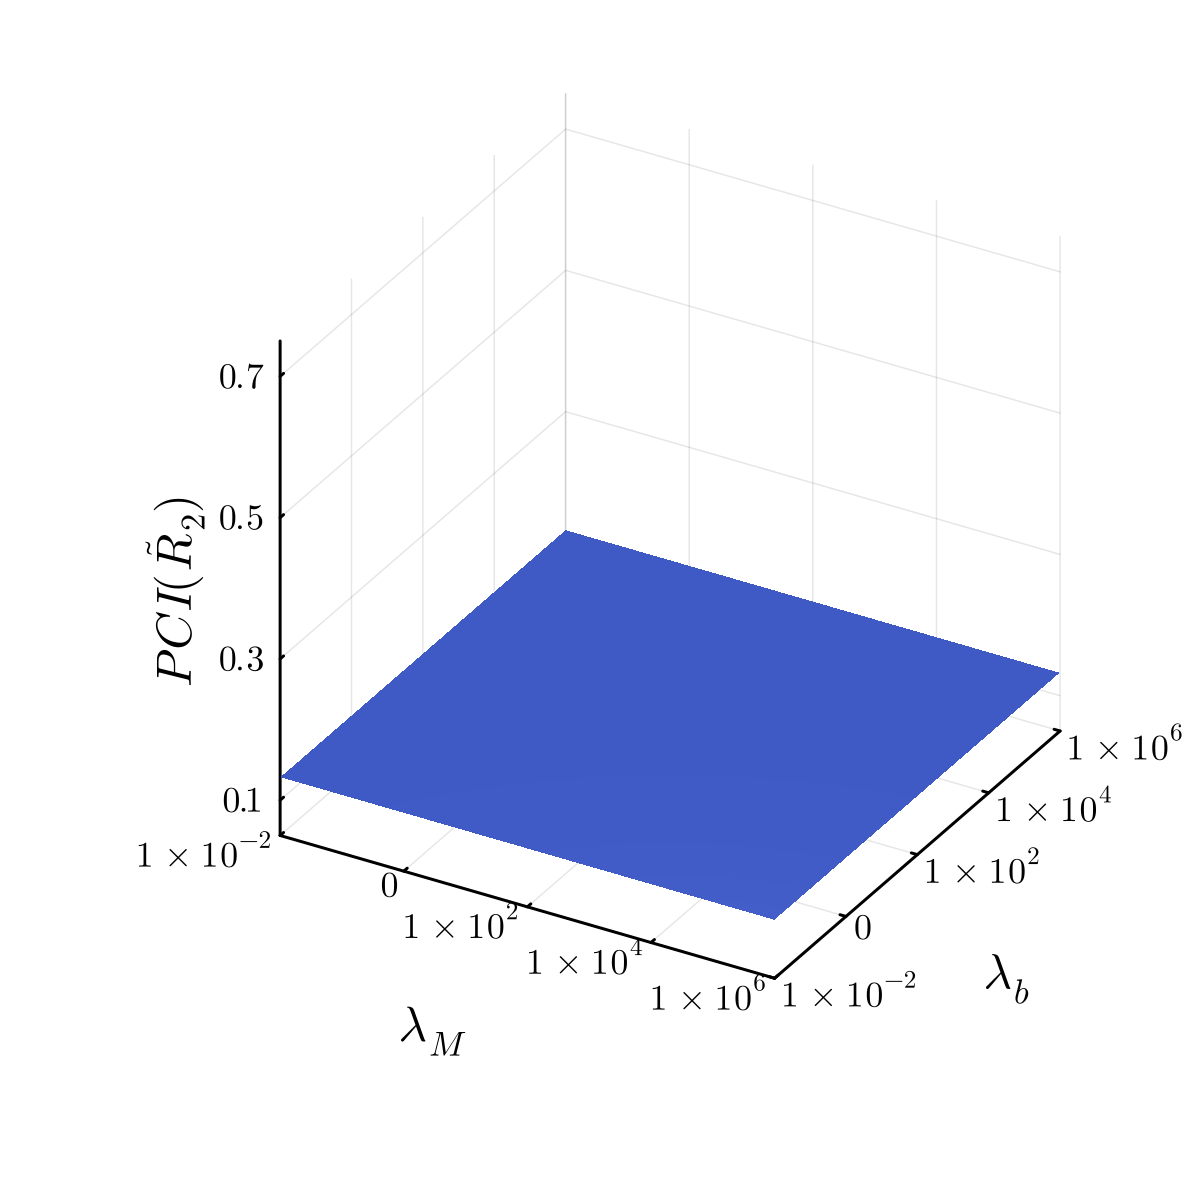

In [71]:
using Plots.PlotMeasures
gr()

fig = surface(
    log10.(λs),
    log10.(λs),
    PCI,
    colorbar=false,
    xlabel = L"\lambda_{\bf M}",
    ylabel = L"\lambda_b",
    zlabel = L"{PCI}({\tilde R}_2)",
    xlims = [-2,6],ylims = [-2,6],zlims = [0.05,0.75],
    color=:turbo,
    dpi = 300,size = (400,400),
)
zticks!(fig,[0.1,0.3,0.5,0.7],[L"0.1",L"0.3",L"0.5",L"0.7"])
xticks!(fig,[-2,0,2,4,6],[L"1\times 10^{-2}",L"0",L"1\times 10^{2}",L"1\times 10^{4}",L"1\times 10^{6}"])
yticks!(fig,[-2,0,2,4,6],[L"1\times 10^{-2}",L"0",L"1\times 10^{2}",L"1\times 10^{4}",L"1\times 10^{6}"])

In [5]:
savefig("influence of prior 1.pdf")

"c:\\users\\HaoLi\\Desktop\\论文\\随机偏好关系贝叶斯分析\\influence of prior 1.pdf"

In [69]:
X,L,U,J,r,n,n_J = getdata(log.(R2.R));
u_prior = [0.8224064015012627, 0.07347333311276494, -0.3465735902799726]

b_prior = 0.43274640424085087

PCI = zeros(Float64,9,9)
a = p = 0
λs = [0.01,0.1,1,10,100,1000,10000,100000,1000000]

for i in 1:9
    for j in 1:9
        post = IntervalAHP.iahp_analy(X,L,U,n,n_J,a,p,u_prior,λs[i],b_prior,λs[j]);
        # pu = post["μ"]["mean"]
        # pw = exp.(cat(pu,[0],dims=1))
        # pw = pw./sum(pw)
        # pb = post["b"]["mean"]
        pci = post["gci"];
        PCI[i,j] = pci;
    end
end

PCI = round.(PCI,digits=4)

9×9 Matrix{Float64}:
 0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315
 0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315
 0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315
 0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315
 0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315
 0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315
 0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315
 0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315
 0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315  0.1315

In [64]:

gr()

plot(
    log10.(λs),
    PCI[:,1],
    label = L"\lambda_b = 0.01",
    marker = :circle,
    ylim= [0.0315,0.2315]
)

plot!(
    log10.(λs),
    PCI[:,3],
    label = L"\lambda_b = 1",
    marker = :rect
)

plot!(
    log10.(λs),
    PCI[:,4],
    label =  L"\lambda_b = 10",
    marker = :star5
)

plot!(
    log10.(λs),
    PCI[:,5],
    label =  L"\lambda_b = 100",
    marker = :diamond
)

plot!(
    log10.(λs),
    PCI[:,6],
    label =  L"\lambda_b = 1000",
    marker = :hexagon
)

plot!(
    log10.(λs),
    PCI[:,9],
    label =  L"\lambda_b = 1000000",
    marker = :utriangle
)

plot!(
    dpi = 300,size = (400,400),
)

xlabel!(L"\lambda_{\mathbf{M}}")
ylabel!(L"PCI(\widetilde{\mathbf{R}})")

savefig("influence of prior 2-1.pdf")

"c:\\Users\\Hao\\Desktop\\BaiduSyncdisk\\论文\\随机偏好关系贝叶斯分析\\influence of prior 2-1.pdf"

In [70]:

gr()

plot(
    log10.(λs),
    PCI[1,:],
    label = L"\lambda_{\mathbf{M}} = 0.01",
    marker = :circle,
    ylim= [0.0315,0.2315]
)

plot!(
    log10.(λs),
    PCI[3,:],
    label = L"\lambda_{\mathbf{M}} = 1",
    marker = :rect
)

plot!(
    log10.(λs),
    PCI[4,:],
    label =  L"\lambda_{\mathbf{M}} = 10",
    marker = :star5
)

plot!(
    log10.(λs),
    PCI[5,:],
    label =  L"\lambda_{\mathbf{M}} = 100",
    marker = :diamond
)

plot!(
    log10.(λs),
    PCI[6,:],
    label =  L"\lambda_{\mathbf{M}} = 1000",
    marker = :hexagon
)

plot!(
    log10.(λs),
    PCI[9,:],
    label =  L"\lambda_{\mathbf{M}} = 1000000",
    marker = :utriangle
)

plot!(
    dpi = 300,size = (400,400),
)


xlabel!(L"\lambda_{b}")
ylabel!(L"PCI(\widetilde{\mathbf{R}})")

savefig("influence of prior 2-2.pdf")

"c:\\Users\\Hao\\Desktop\\BaiduSyncdisk\\论文\\随机偏好关系贝叶斯分析\\influence of prior 2-2.pdf"

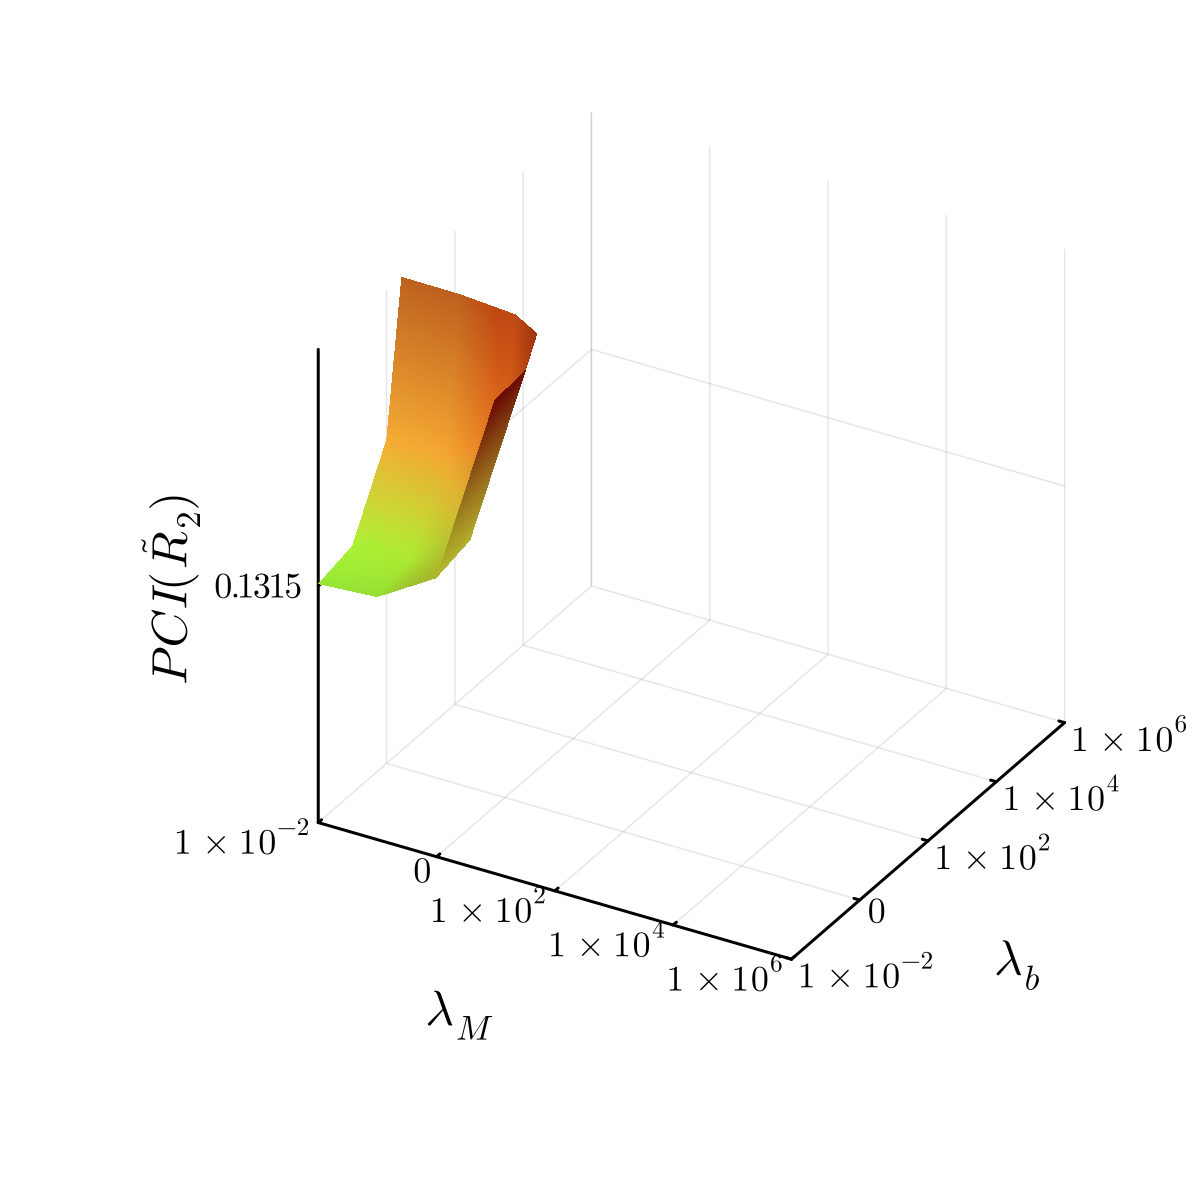

In [91]:
using Plots.PlotMeasures
gr()

fig = surface(
    log10.(λs),
    log10.(λs),
    PCI,
    colorbar=false,
    xlabel = L"\lambda_M",
    ylabel = L"\lambda_b",
    zlabel = L"{PCI}({\tilde R}_2)",
    xlims = [-2,6],ylims = [-2,6],zlims = [0.0315,0.2315],
    color=:turbo,
    dpi = 300,size = (400,400),
)
zticks!(fig,[0.1315],[L"0.1315"])
xticks!(fig,[-2,0,2,4,6],[L"1\times 10^{-2}",L"0",L"1\times 10^{2}",L"1\times 10^{4}",L"1\times 10^{6}"])
yticks!(fig,[-2,0,2,4,6],[L"1\times 10^{-2}",L"0",L"1\times 10^{2}",L"1\times 10^{4}",L"1\times 10^{6}"])

In [26]:
savefig("influence of prior 2.pdf")

"c:\\users\\HaoLi\\Desktop\\论文\\随机偏好关系贝叶斯分析\\influence of prior 2.pdf"

In [92]:
X,L,U,J,r,n,n_J = getdata(log.(R2.R));
u_prior = [0,0,0]

b_prior = 0

PCI = zeros(Float64,9,9)
a = p = 0
λs = [0.01,0.1,1,10,100,1000,10000,100000,1000000]

for i in 1:9
    for j in 1:9
        post = IntervalAHP.iahp_analy(X,L,U,n,n_J,a,p,u_prior,λs[i],b_prior,λs[j]);
        # pu = post["μ"]["mean"]
        # pw = exp.(cat(pu,[0],dims=1))
        # pw = pw./sum(pw)
        # pb = post["b"]["mean"]
        pci = post["gci"];
        PCI[i,j] = pci;
    end
end

In [99]:

gr()

plot(
    log10.(λs),
    PCI[:,1],
    label = L"\lambda_b = 0.01",
    marker = :circle,
    legend_column = 2,
    leg = :topleft,
    ylim = [0.1,1.85]
)

plot!(
    log10.(λs),
    PCI[:,3],
    label = L"\lambda_b = 1",
    marker = :rect
)

plot!(
    log10.(λs),
    PCI[:,4],
    label =  L"\lambda_b = 10",
    marker = :star5
)

plot!(
    log10.(λs),
    PCI[:,5],
    label =  L"\lambda_b = 100",
    marker = :diamond
)

plot!(
    log10.(λs),
    PCI[:,6],
    label =  L"\lambda_b = 1000",
    marker = :hexagon
)

plot!(
    log10.(λs),
    PCI[:,9],
    label =  L"\lambda_b = 1000000",
    marker = :utriangle
)

plot!(
    dpi = 300,size = (400,400),
)

xlabel!(L"\lambda_{\mathbf{M}}")
ylabel!(L"PCI(\widetilde{\mathbf{R}})")

savefig("influence of prior 3-1.pdf")

"c:\\Users\\Hao\\Desktop\\BaiduSyncdisk\\论文\\随机偏好关系贝叶斯分析\\influence of prior 3-1.pdf"

In [100]:

gr()

plot(
    log10.(λs),
    PCI[1,:],
    label = L"\lambda_{\mathbf{M}} = 0.01",
    marker = :circle,
    legend_column = 2,
    leg = :topleft,
    ylim = [0.1,1.85]
)

plot!(
    log10.(λs),
    PCI[3,:],
    label = L"\lambda_{\mathbf{M}} = 1",
    marker = :rect
)

plot!(
    log10.(λs),
    PCI[4,:],
    label =  L"\lambda_{\mathbf{M}} = 10",
    marker = :star5
)

plot!(
    log10.(λs),
    PCI[5,:],
    label =  L"\lambda_{\mathbf{M}} = 100",
    marker = :diamond
)

plot!(
    log10.(λs),
    PCI[6,:],
    label =  L"\lambda_{\mathbf{M}} = 1000",
    marker = :hexagon
)

plot!(
    log10.(λs),
    PCI[9,:],
    label =  L"\lambda_{\mathbf{M}} = 1000000",
    marker = :utriangle
)

plot!(
    dpi = 300,size = (400,400),
)


xlabel!(L"\lambda_{b}")
ylabel!(L"PCI(\widetilde{\mathbf{R}})")

savefig("influence of prior 3-2.pdf")

"c:\\Users\\Hao\\Desktop\\BaiduSyncdisk\\论文\\随机偏好关系贝叶斯分析\\influence of prior 3-2.pdf"

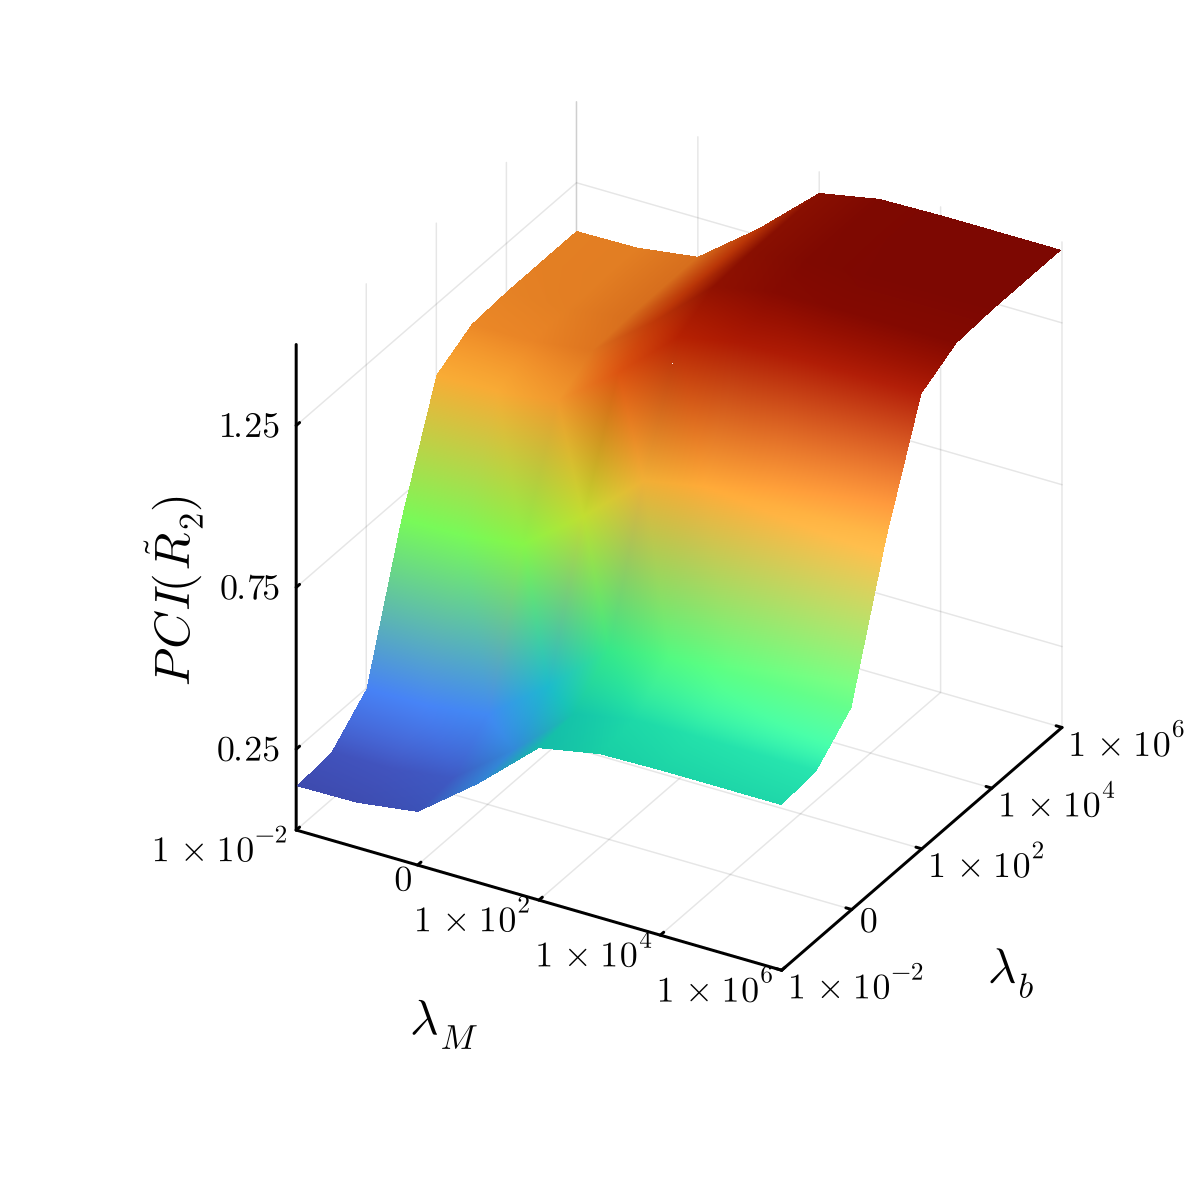

In [21]:
using Plots.PlotMeasures
gr()

fig = surface(
    log10.(λs),
    log10.(λs),
    PCI,
    colorbar=false,
    xlabel = L"\lambda_{\bf M}",
    ylabel = L"\lambda_b",
    zlabel = L"{PCI}({\tilde R}_2)",
    xlims = [-2,6],ylims = [-2,6],zlims = [0,1.5],
    color=:turbo,
    dpi = 300,size = (400,400),
)
zticks!(fig,[0.25,0.75,1.25],[L"0.25",L"0.75",L"1.25"])
xticks!(fig,[-2,0,2,4,6],[L"1\times 10^{-2}",L"0",L"1\times 10^{2}",L"1\times 10^{4}",L"1\times 10^{6}"])
yticks!(fig,[-2,0,2,4,6],[L"1\times 10^{-2}",L"0",L"1\times 10^{2}",L"1\times 10^{4}",L"1\times 10^{6}"])

In [22]:
savefig("influence of prior 3.pdf")

"c:\\users\\HaoLi\\Desktop\\论文\\随机偏好关系贝叶斯分析\\influence of prior 3.pdf"